<a href="https://colab.research.google.com/github/NormanNeumann/Intro_to_pytorch/blob/main/COMP8539_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Adopted from https://tintn.github.io/Implementing-Vision-Transformer-from-Scratch/, https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# You may get a sense of the how final accuracy looks like on https://github.com/kentaroy47/vision-transformers-cifar10
# Author: Changlin Song. Checked by Enze Tao.

In [ ]:
# Add pathes of mounted Projects.
# This allows you to access your google drive so that you can store the state_dict or whatever you want.
# You should modify the following path according to your own google drive configuration if you need it.
import sys
sys.path.append('/content/drive/MyDrive/COMP8539/assignment1')
path_prefix = '/content/drive/MyDrive/COMP8539/assignment1'

2. Import Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from PIL import Image
import os

# Seed every thing for reproduct
SEED = 8539
torch.manual_seed(SEED) # Setting the seed
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

3. Prepare CIFAR-10 Dataset

In [ ]:
@dataclass
class CIFAR10_Dataset(Dataset):
    root_dir: str                    # Path to CIFAR-10 data folder
    train: bool = True               # Whether to load train or test set
    transform: transforms.Compose = None  # Image transforms (To be filled in)

    def __post_init__(self):
        # TODO: Load file paths and labels
        # You can use torchvision.datasets.CIFAR10 as a reference or use your own file loader
        self.image_paths = []  # Fill with list of image file paths
        self.labels = []       # Fill with corresponding labels

        # Note that writing your own dataclass can be beneficial for your feature research when you
        # need to construct a new dataset.

        # Example: Load from torchvision and extract data manually (optional)
        # from torchvision.datasets import CIFAR10
        # cifar = CIFAR10(root=self.root_dir, train=self.train, download=True)
        # self.image_paths = cifar.data
        # self.labels = cifar.targets

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # TODO: Load and return an image and its label
        # image = Image.open(self.image_paths[idx]).convert('RGB')  # if using image files
        # If using numpy arrays from torchvision.datasets.CIFAR10:
        # image = Image.fromarray(self.image_paths[idx])
        label = self.labels[idx]

        # Apply transformation if available
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Data transforms for CIFAR-10 (standard normalization)
# Note that you are free to use your own data augmentation.
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Load datasets
train_set = CIFAR10_Dataset(root='./data', train=True,
                                         download=True, transform=transform_train)
test_set = CIFAR10_Dataset(root='./data', train=False,
                                        download=True, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]


4. Define Baseline ViT Model (Task 3.1)

![](https://cdn.jsdelivr.net/gh//Charlemagnescl/image-host/202508030029392.png)
Dosovitskiy A, Beyer L, Kolesnikov A, et al. An image is worth 16x16 words: Transformers for image recognition at scale[J]. arXiv preprint arXiv:2010.11929, 2020.

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange, repeat

def pair(t):
    """Helper to ensure tuple format for sizes."""
    return t if isinstance(t, tuple) else (t, t)

# Patch Embedding Layer

Transformers accept 1D sequences. To handle 2D images, we reshape an image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P,P)$ is the resolution of each image patch, and $N = HW / P^2$ is the resulting number of patches. The 1D patch sequences ($\mathbf{x}_p$) will be map to $D$ dimensions with a trainable linear projection.

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, dim, **kwargs):
        """
        Splits image into non-overlapping patches and embeds them into a vector space.
        """
        super().__init__()
        self.num_channels = kwargs.get('num_channels', 3)

        image_size = pair(image_size)
        patch_size = pair(patch_size)

        image_height, image_width = image_size
        patch_height, patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, \
            'Image dimensions must be divisible by patch size'

        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = self.num_channels * patch_height * patch_width

        # TODO: implement rearrange and a linear projection
        self.to_patch_embedding = nn.Sequential(
            # rearrange('B C (H p1) (W p2) -> B (H W) (p1 p2 C)', ...)
            # nn.Linear(..., dim)
        )

    def forward(self, x):
        # TODO: apply patch embedding
        pass

# Embedding Layer (Patch + Positional + CLS)

ViT use a learnable embedding $\mathbf{x}_\text{class}$ to serve as the representation of the image, which will be prepend to the embedded image patches($\mathbf{Z}_{0:N+1} = [\mathbf{x}_\text{class} \quad , \mathbf{x}_p]$). ViT use standard learnable 1D position embeddings $\mathbf{P}_{0:N+1} = [\mathbf{P}_0, \mathbf{P}_1, \ldots, \mathbf{P}_{N+1}]$. The input of the transformer layers is the summation of $\mathbf{Z}_{0:N+1}$ and $\mathbf{P}_{0:N+1}$.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, image_size, patch_size, dim, **kwargs):
        super().__init__()
        self.patch_embedding = PatchEmbedding(image_size, patch_size, dim, **kwargs)

        # TODO: define CLS token and positional embedding
        self.cls_token = ...
        self.pos_embedding = ...
        self.dropout = nn.Dropout(kwargs.get('emb_dropout', 0.1))

    def forward(self, x):
        # TODO:
        # 1. Patch embed
        # 2. Add CLS token
        # 3. Add positional embedding
        # 4. Apply dropout
        pass

Multi-Head Self-Attention

![](https://cdn.jsdelivr.net/gh//Charlemagnescl/image-host/202508031017288.png)

Zhang, A., et al, Dive into Deep Learning. Cambridge University Press, 2023.

In multi-head self attention, we have the input $\mathbf{x}$ serves as the queries, keys, values ($\mathbf{q,k,v}$) simultaneouly. The attention output of the $i$-th head is
$$\mathbf{h}_i = f(\mathbf{W}^{(q)}_i \mathbf{q}, \mathbf{W}^{(k)}_i \mathbf{k}, \mathbf{W}^{(v)}_i \mathbf{v}) \in \mathbb{R}^{D / N_\text{head}}$$
where $\mathbf{W}^{(q)}_i, \mathbf{W}^{(k)}_i, \mathbf{W}^{(v)}_i \in \mathbb{R}^{D / N_\text{head} \  \times D}$ are learnable parameters, and $f$ is scaled dot product attention
$$f(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \operatorname{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}}\right)\mathbf{V} \in \mathbb{R}^{n \times d}$$
where $\mathbf{Q}, \mathbf{K}, \mathbf{V} \in \mathbb{R}^{n \times d}$.

The multi-head attention output is another linear transformation via learnable parameters $\mathbf{W}_o \in \mathbb{R}^{D \times D}$ of the concatenation of $N_\text{head} \ $ heads
$$\mathbf{W}_o \begin{bmatrix}\mathbf{h}_1 \\ \vdots \\ \mathbf{h}_{N_\text{head}}\end{bmatrix} \in \mathbb{R}^{D}$$

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        # TODO: Define linear layers for qkv, dropout layers, scaling factor
        self.norm = ...
        self.qkv = ...
        self.proj = ...
        self.attn_drop = ...
        self.proj_drop = ...
        self.scale = ...

    def forward(self, x):
        # TODO:
        # 1. Normalize input
        # 2. Compute q, k, v
        # 3. Compute scaled dot-product attention
        # 4. Apply dropout
        # 5. Project output
        pass

# Feedforward MLP

The MLP contains two layers with a GELU non-linearity.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        # TODO: Build 2-layer MLP with dropout and GELU
        # Don't forget to normalize the input, and use dropout after each Linear Layer!
        self.net = ...

    def forward(self, x):
        return self.net(x)

NameError: name 'nn' is not defined

# Transformer Encoder Block (use your MultiHeadAttention and FeedForward layer)

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth=6, num_heads=8, mlp_dim=2048, dropout=0.1):
        super().__init__()
        # TODO: Stack multiple attention + FFN blocks
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                # MultiHeadAttention(dim, num_heads, dropout=dropout),
                # FeedForward(dim, mlp_dim, dropout=dropout)
            ]))
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # TODO: Residual attention and FFN connections
        for attn, ff in self.layers:
            x = ...
        return self.norm(x)

# Vision Transformer Classifier

$$\mathbf{z}^{0} = [\mathbf{x}_\text{class} \ \ , \mathbf{x}_p] + \mathbf{P},$$
$$\tilde{\mathbf{z}}^{l} = \operatorname{MSA}(\operatorname{LN}(\mathbf{z}^{l-1})) + \mathbf{z}^{l-1}, \quad l = 1, \ldots, L$$
$$\mathbf{z}^{l} = \operatorname{MLP}(\operatorname{LN}(\tilde{\mathbf{z}}^{l})) + \tilde{\mathbf{z}}^{l}, \quad l = 1, \ldots, L$$
$$\mathbf{y} = \operatorname{LN}(\mathbf{z}^L_0)$$

In [ ]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout, emb_dropout):
        super().__init__()
        # TODO: Combine embedding, transformer, MLP head
        self.embeddings = ...
        self.encoder = ...
        self.mlp_head = ...

    def forward(self, img):
        # TODO:
        # 1. Embed input image
        # 2. Pass through transformer
        # 3. Use CLS token for classification
        pass

5. Training Setup

Save your checkpoint

In [ ]:
def save_checkpoint(model, optimizer, epoch, train_loss_history, val_loss_history,
                    train_acc_history, val_acc_history, path="checkpoint.pth"):
    """
    Saves model state, optimizer state, epoch, and training history.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to {path}")

Load your checkpoint

In [ ]:
def load_checkpoint(model, optimizer, path="checkpoint.pth", device='cpu'):
    """
    Loads model and optimizer states, epoch, and training history.
    Returns model, optimizer, last epoch, and histories.
    """
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    train_acc_history = checkpoint['train_acc_history']
    val_acc_history = checkpoint['val_acc_history']

    print(f"Checkpoint loaded from {path} (epoch {epoch})")

    return model, optimizer, epoch, train_loss_history, val_loss_history, train_acc_history, val_acc_history

6. Training and Validation Loop

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm



def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        # TODO: Move inputs and labels to device
        # inputs, labels = ...

        # TODO: Zero gradients
        # optimizer.zero_grad()

        # TODO: Forward pass
        # outputs = ...

        # TODO: Compute loss
        # loss = ...

        # TODO: Backward pass and optimizer step
        # loss.backward()
        # optimizer.step()

        # TODO: Update metrics
        # running_loss += ...
        # correct += ...
        # total += ...

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


  def evaluate(model, dataloader, criterion, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            # TODO: Move to device
            # inputs, labels = ...

            # TODO: Forward pass
            # outputs = ...

            # TODO: Compute loss
            # loss = ...

            # TODO: Update metrics
            # loss_sum += ...
            # correct += ...
            # total += ...

    epoch_loss = loss_sum / len(dataloader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


Setup training config, resume your checkpoint if needed.

In [ ]:
# Number of training epochs
num_epochs = 50

# Save every N epochs or best model only
save_every = 10

# Initialize model and optimizer as usual
device = 'cuda' if torch.cuda.is_available() # Use GPU if you have
model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=512,
    dropout=0.1,
    emb_dropout=0.1
).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = ...
optimizer = ...

# Track training
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = []

# Restore checkpoint if needed
resume = True
start_epoch = 0

if resume:
    model, optimizer, start_epoch, train_loss_history, val_loss_history, train_acc_history, val_acc_history = \
        load_checkpoint(model, optimizer, path=os.path.join(path_prefix,"checkpoint.pth"), device=device)

Start training

In [ ]:
for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # Save checkpoint
    if (epoch + 1) % save_every == 0:
        save_checkpoint(model, optimizer, epoch + 1,
                        train_loss_history, val_loss_history,
                        train_acc_history, val_acc_history, path=os.path.join(path_prefix,"checkpoint.pth"))

7. Plot Results

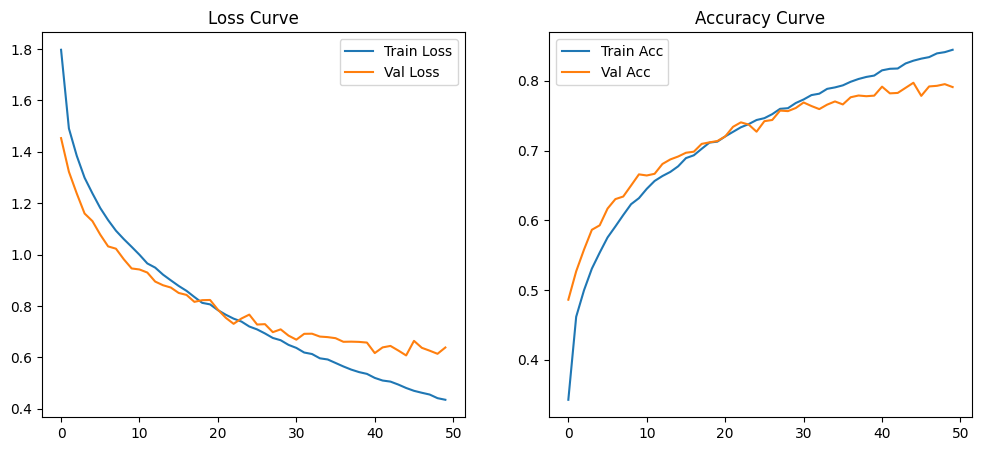

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Final Accuracy on Test Set

In [ ]:
final_test_loss, final_test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {final_test_acc * 100:.2f}%")

Final Test Accuracy: 79.10%


# Task 3.2: Ablation Studies

We will now define a function to automate experiments with different configurations.

In [ ]:
def run_ablation(patch_size=4, dim=256, depth=6, heads=8):
    print(f"Running with patch={patch_size}, dim={dim}, depth={depth}, heads={heads}")
    model = ViT(
        image_size=32,
        patch_size=patch_size,
        num_classes=10,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=dim * 2,
        dropout=0.1,
        emb_dropout=0.1
    ).to(device)

    optimizer = ...
    criterion = ...
    device = ...
    best_val_acc = 0

    for epoch in range(10):  # Short training for ablation
        train_one_epoch(model, train_loader, optimizer, criterion, device)

        _, val_acc = evaluate(model, test_loader)
        best_val_acc = max(best_val_acc, val_acc)

    print(f"Best Val Accuracy: {best_val_acc*100:.2f}%\n")
    return best_val_acc

Run Ablations

In [ ]:
# Patch Size Ablation
for patch in [2, 4, 8]:
    run_ablation(patch_size=patch)

# Embedding Dimension Ablation
for dim in [96, 192, 256]:
    run_ablation(dim=dim)

# Number of Layers
for depth in [4, 6, 12]:
    run_ablation(depth=depth)

# Attention Heads
for heads in [1, 3, 8]:
    run_ablation(heads=heads)

Running with patch=2, dim=256, depth=6, heads=8
